# Causal Analysis of Synthetic Dataset

In [235]:
import networkx as nx
import numpy as np
import pandas as pd
import scipy
import dowhy
import dowhy.plotter as plotter
from dowhy.do_why import CausalModel
import random
import seaborn as sns

sns.set_context("notebook")
%matplotlib inline

random.seed(0)
np.random.seed(0)

TREATMENT_COL = 'ContinentOfBirth'
#TREATMENT_COL = 'CitizenshipContinent'

treatment_subdimensions = ['CitizenshipCountry'] if TREATMENT_COL == 'CitizenshipContinent' else ['CountryOfBirth']

OUTCOME_NAME = 'Last Name Correct'

TREATMENT = 'T'
OUTCOME = 'O'

In [236]:
dataset = pd.read_csv('data/synthetic-dataset-scenario-B.csv')
dataset.columns

Index(['Source', 'Last Name', 'CountryOfBirth', 'ContinentOfBirth',
       'CitizenshipCountry', 'CitizenshipContinent', 'NumChildren',
       'MaritalStatus', 'Last Name Correct'],
      dtype='object')

In [237]:
# Introduce binary treatment column as proposed by Data X-Ray
dataset[TREATMENT] = dataset[TREATMENT_COL] == 'Asia'
dataset.rename({OUTCOME_NAME: OUTCOME}, axis=1, inplace=True)
dataset.head()

COVARIATES = dataset.drop([TREATMENT, OUTCOME, TREATMENT_COL, 'Last Name'] + treatment_subdimensions, axis=1).columns.values
CONT_COVARIATES = ['NumChildren']
CAT_COVARIATES = list(c for c in COVARIATES if c not in CONT_COVARIATES)

## Analysis with `doWhy`

In [162]:
graph = nx.DiGraph()

# potential confounders
for col in COVARIATES:
    graph.add_edge(col, TREATMENT)
    graph.add_edge(col, OUTCOME)
    
#graph.add_edge('Unobserved Confounders', 'Treatment')
#graph.add_edge('Unobserved Confounders', 'Last Name Correct')

# Assumed causal relation
graph.add_edge(TREATMENT, OUTCOME)

['CitizenshipCountry', 'MaritalStatus', 'CitizenshipContinent', 'NumChildren', 'Source']
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
Model to find the causal effect of treatment Treatment on outcome LastNameCorrect
Using Matplotlib for plotting


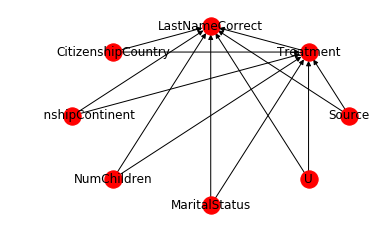

In [163]:
model = CausalModel(data = dataset, treatment=TREATMENT, outcome=OUTCOME, graph=''.join(nx.generate_gml(graph)))
model.view_model()

In [164]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'CitizenshipCountry', 'MaritalStatus', 'CitizenshipContinent', 'Source', 'NumChildren', 'U'}


{'observed': 'yes'}
{'observed': 'yes'}
{'observed': 'yes'}
{'observed': 'yes'}
{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                                         
──────────(Expectation(LastNameCorrect|CitizenshipCountry,MaritalStatus,Citize
dTreatment                                                                    

                                   
nshipContinent,Source,NumChildren))
                                   
Estimand assumption 1, Unconfoundedness: If U→Treatment and U→LastNameCorrect then P(LastNameCorrect|Treatment,CitizenshipCountry,MaritalStatus,CitizenshipContinent,Source,NumChildren,U) = P(LastNameCorrect|Treatment,CitizenshipCountry,MaritalStatus,CitizenshipContinent,Source,NumChildren)
### Estimand : 2
Estimand name: iv
No such variable found!



In [165]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name='backdoor.propensity_score_stratification')
print(causal_estimate)
print('Causal Estimate is ' + str(causal_estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: LastNameCorrect~Treatment+CitizenshipCountry+MaritalStatus+CitizenshipContinent+Source+NumChildren


PropensityScoreStratificationEstimator


C:\Users\Amnesix\DOCUME~1\KIT---~1\00-AUS~1\Studium\WINTER~1\CAUSAL~1\mldcpy\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                                         
──────────(Expectation(LastNameCorrect|CitizenshipCountry,MaritalStatus,Citize
dTreatment                                                                    

                                   
nshipContinent,Source,NumChildren))
                                   
Estimand assumption 1, Unconfoundedness: If U→Treatment and U→LastNameCorrect then P(LastNameCorrect|Treatment,CitizenshipCountry,MaritalStatus,CitizenshipContinent,Source,NumChildren,U) = P(LastNameCorrect|Treatment,CitizenshipCountry,MaritalStatus,CitizenshipContinent,Source,NumChildren)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: LastNameCorrect~Treatment+CitizenshipCountry+MaritalStatus+CitizenshipContinent+Source+NumChildren
## Estimate
Value: -0.1383356409548203

Causal Estimate

In [44]:
res_random = model.refute_estimate(identified_estimand, causal_estimate, method_name='random_common_cause')
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: l~t+MaritalStatus+NumChildren+CitizenshipContinent+Source+CitizenshipCountry+w_random


Refute: Add a Random Common Cause
Estimated effect:(-0.1282816229116945,)
New effect:(-0.13454653937947494,)



In [45]:
res_placebo = model.refute_estimate(identified_estimand, causal_estimate, method_name='placebo_treatment_refuter', placebo_type='permute')
print(res_placebo)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: l~placebo+MaritalStatus+NumChildren+CitizenshipContinent+Source+CitizenshipCountry


Refute: Use a Placebo Treatment
Estimated effect:(-0.1282816229116945,)
New effect:(0.015214797136038186,)



In [46]:
res_subset = model.refute_estimate(identified_estimand, causal_estimate, method_name='data_subset_refuter', subset_fraction=0.9)
print(res_subset)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: l~t+MaritalStatus+NumChildren+CitizenshipContinent+Source+CitizenshipCountry


Refute: Use a subset of data
Estimated effect:(-0.1282816229116945,)
New effect:(-0.1387876780390858,)

